# Approach overview
<table>
    <tr>
        <td><img src="MetaModel.png" width="450" height="450" /></td> 
        <td><img src="MetaReco.png" width="450" height="450" /></td>
    </tr>
</table>

    Source: A meta-learning approach for selecting image segmentation algorithm, G J Aguiar et al.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from skimage import io
from skimage.feature import hog
from skimage import data, exposure, color, segmentation
from sklearn import model_selection
#from exif import Image
from PIL import Image
from collections import defaultdict
import operator
from skimage import feature

seed = 1234

In [2]:
%matplotlib inline

# Extracting meta features from original images

In [3]:
categories = os.listdir('leaf_images')
image_titles = []
for i in range(len(categories)):
    file_path = "leaf_images\\" + categories[i] + "\\ORIG"
    image_names = os.listdir(file_path)
    images_path = ["leaf_images\\" + categories[i] + "\\ORIG\\" + img for img in image_names]
    image_titles.append(images_path)
images = sum(image_titles,[])
images

['leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide1.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide10.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide2.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide3.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide4.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide5.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide6.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide7.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide8.PNG',
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide9.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide1.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide2.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide3.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide4.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide5.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide6.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide7.PNG',
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide8.PNG',
 'leaf_imag

In [4]:
features = pd.DataFrame(images,columns=['image'])
features.head()

,image
0,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG
1,leaf_images\Cabernet_Franc_Old\ORIG\Slide10.PNG
2,leaf_images\Cabernet_Franc_Old\ORIG\Slide2.PNG
3,leaf_images\Cabernet_Franc_Old\ORIG\Slide3.PNG
4,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG


In [5]:
def channel_mean(path):
    img = cv2.imread(path,1)
    mean = [round(img[:,:,i].mean(),2) for i in range(img.shape[-1])]
    img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    for i in range(3):
        mean.append(round(img_hsv[:,:,i].mean(),2))
    return mean

def channel_std(path):
    img = cv2.imread(path,1)
    std = [round(img[:,:,i].std(),2) for i in range(img.shape[-1])]
    img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    for i in range(3):
        std.append(round(img_hsv[:,:,i].std(),2))
    return std

def average_pixel_width(path):
    im = IMG.open(path)    
    im_array = np.asarray(im.convert(mode='L'))
    edges_sigma1 = feature.canny(im_array, sigma=3)
    apw = (float(np.sum(edges_sigma1)) / (im.size[0]*im.size[1]))
    return apw*100

def getImageSize(path):
    st = os.stat(path)
    return st.st_size

def getDimension(path):
    img = cv2.imread(path)
    return img.shape

#https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
def getBlurnessScore(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(image, cv2.CV_64F).var() #low score indicates blurry image
    return fm

def getExif(path):
    exif = {}
    with open(path,'rb') as img_file:
        image = Image(img_file)
    try:    
        exif['aperture_value'] = round(image.aperture_value,3)
    except:
        exif['aperture_value'] = None
    try:
        exif['brightness_value'] = round(image.brightness_value,3)
    except:
        exif['brightness_value'] = None
    try:
        exif['compression'] = image.compression
    except:
        exif['compression'] = None
    
    return exif

def color_analysis(img):
    # obtain the color palatte of the image 
    palatte = defaultdict(int)
    
    for pixel in Image.Image.getdata(img):
        palatte[pixel] += 1
    
    # sort the colors present in the image 
    sorted_x = sorted(palatte.items(), key=operator.itemgetter(1), reverse = True)
    
    light_shade, dark_shade, shade_count, pixel_limit = 0, 0, 0, 25
    for i, x in enumerate(sorted_x[:pixel_limit]):
        if all(xx <= 50 for xx in x[0][:3]): ## dull : too much darkness 
            dark_shade += x[1]
        if all(xx >= 200 for xx in x[0][:3]): ## bright : too much whiteness 
            light_shade += x[1]
        shade_count += x[1]
    #print(light_shade,dark_shade,shade_count)
    
    light_percent = round((float(light_shade)/shade_count)*100, 2)
    dark_percent = round((float(dark_shade)/shade_count)*100, 2)
    return light_percent, dark_percent

def perform_color_analysis(img, flag):
    im = Image.open(img) #.convert("RGB")
    
    # cut the images into two halves as complete average may give bias results
    size = im.size
    #print(size)

    try:
        light_percent, dark_percent = color_analysis(im)        
    except Exception as e:
        #print(e)
        return None
    
    if flag == 'black':
        return dark_percent
    elif flag == 'white':
        return light_percent
    else:
        return None
    
def contour_info(path):
    c_info = []
    img = cv2.imread(path,0)
    _,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    all_contours,_ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    ext_contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(ext_contours,key=len,reverse=True)
    c_info.append(len(all_contours))
    c_info.append(len(ext_contours))
    contour_len = [len(c) for c in sorted_contours]
    len_sum = sum(contour_len)
    c_perc_len = [i/len_sum for i in contour_len]
    c_info.append([round(c_perc_len[0],2),round(sum(c_perc_len[:5]),2),round(sum(c_perc_len[:10]),2)])
    return c_info     

def sobel_whiteness(path):
    img = cv2.imread(path,0)
    sobelX = cv2.Sobel(img,cv2.CV_64F,1,0)
    sobelX = np.uint8(np.absolute(sobelX))

    sobelY = cv2.Sobel(img,cv2.CV_64F,0,1)
    sobelY = np.uint8(np.absolute(sobelY))

    sobel = cv2.bitwise_or(sobelX,sobelY)
    sobel_white = np.sum(sobel==255)
    return sobel_white

In [6]:
features['mean'] = features['image'].apply(channel_mean)
features['mean_r'] = features['mean'].apply(lambda x: x[2])
features['mean_g'] = features['mean'].apply(lambda x: x[1])
features['mean_b'] = features['mean'].apply(lambda x: x[0])
features['mean_h'] = features['mean'].apply(lambda x: x[3])
features['mean_s'] = features['mean'].apply(lambda x: x[4])
features['mean_v'] = features['mean'].apply(lambda x: x[5])
features['std'] = features['image'].apply(channel_std)
features['std_r'] = features['std'].apply(lambda x: x[2])
features['std_g'] = features['std'].apply(lambda x: x[1])
features['std_b'] = features['std'].apply(lambda x: x[0])
features['std_h'] = features['std'].apply(lambda x: x[3])
features['std_s'] = features['std'].apply(lambda x: x[4])
features['std_v'] = features['std'].apply(lambda x: x[5])
features['image_size'] = features['image'].apply(getImageSize)
features['dimension'] = features['image'].apply(getDimension)
features['width'] = features['dimension'].apply(lambda x: x[0])
features['height'] = features['dimension'].apply(lambda x: x[1])
features['blurness'] = features['image'].apply(getBlurnessScore)
features['dullness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'black'))
features['whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
#features['exif_meta'] = features['image'].apply(getExif)
features.drop(['mean','std','dimension'],axis=1,inplace=True)

In [7]:
features['c_info'] = features['image'].apply(contour_info)
features['total_cntr_cnt'] = features['c_info'].apply(lambda x: x[0])
features['ext_cntr_cnt'] = features['c_info'].apply(lambda x: x[1])
features['cnt1_perc'] = features['c_info'].apply(lambda x: x[2][0])
features['cnt1to5_perc'] = features['c_info'].apply(lambda x: x[2][1])
features['cnt1to10_perc'] = features['c_info'].apply(lambda x: x[2][2])
features.drop(['c_info'],axis=1,inplace=True)

In [8]:
features['sobel_pw'] = features['image'].apply(sobel_whiteness)

In [9]:
features.describe()

,mean_r,mean_g,mean_b,mean_h,mean_s,mean_v,std_r,std_g,std_b,std_h,...,height,blurness,dullness,whiteness,total_cntr_cnt,ext_cntr_cnt,cnt1_perc,cnt1to5_perc,cnt1to10_perc,sobel_pw
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,...,82.0,82.000000,82.0,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,143.669268,150.540732,111.991707,50.583415,72.234024,154.850732,44.120610,44.986829,40.273537,24.937439,...,1771.0,108.907493,0.0,0.359024,10551.317073,4232.060976,0.368171,0.502439,0.532317,3592.573171
std,14.198870,8.593638,12.536746,22.144530,35.649437,11.167552,14.484672,6.753870,14.648672,15.334280,...,0.0,53.886592,0.0,2.335996,7734.716961,3440.741516,0.232385,0.226675,0.231070,2270.039783
min,123.900000,137.730000,78.030000,23.310000,30.550000,140.150000,23.030000,29.490000,20.480000,3.370000,...,1771.0,11.416236,0.0,0.000000,83.000000,1.000000,0.060000,0.180000,0.210000,497.000000
25%,133.305000,144.152500,104.542500,30.030000,43.802500,146.447500,33.017500,40.767500,27.685000,7.597500,...,1771.0,59.590922,0.0,0.000000,1685.750000,1457.500000,0.192500,0.330000,0.352500,2050.000000
50%,138.105000,147.645000,113.460000,50.305000,53.705000,152.255000,38.320000,44.955000,33.355000,32.600000,...,1771.0,106.938812,0.0,0.000000,11322.500000,3712.000000,0.310000,0.425000,0.450000,3066.500000
75%,153.027500,156.490000,121.407500,68.272500,109.527500,162.187500,57.782500,48.417500,53.885000,37.965000,...,1771.0,141.929420,0.0,0.000000,16394.750000,6568.750000,0.492500,0.647500,0.710000,4929.750000
max,187.350000,179.930000,134.260000,97.800000,144.930000,191.350000,76.880000,60.080000,71.860000,57.070000,...,1771.0,243.662145,0.0,17.820000,28661.000000,15175.000000,1.000000,1.000000,1.000000,14775.000000


In [10]:
features

,image,mean_r,mean_g,mean_b,mean_h,mean_s,mean_v,std_r,std_g,std_b,...,height,blurness,dullness,whiteness,total_cntr_cnt,ext_cntr_cnt,cnt1_perc,cnt1to5_perc,cnt1to10_perc,sobel_pw
0,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,132.58,141.13,110.01,63.12,47.35,142.61,39.44,48.97,26.45,...,1771,133.715318,0.0,0.0,12933,6866,0.21,0.32,0.34,2778
1,leaf_images\Cabernet_Franc_Old\ORIG\Slide10.PNG,137.29,152.04,124.95,61.43,44.35,153.32,27.44,35.69,30.41,...,1771,130.354697,0.0,0.0,20352,5153,0.23,0.38,0.40,4406
2,leaf_images\Cabernet_Franc_Old\ORIG\Slide2.PNG,127.90,141.19,102.42,64.61,60.71,142.77,38.60,50.02,22.00,...,1771,150.037577,0.0,0.0,10533,6247,0.16,0.25,0.26,3640
3,leaf_images\Cabernet_Franc_Old\ORIG\Slide3.PNG,126.87,139.74,104.85,67.79,58.38,141.68,40.38,50.66,27.85,...,1771,133.342142,0.0,0.0,12312,4789,0.21,0.37,0.40,3365
4,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,135.61,151.34,109.09,50.52,59.19,152.44,35.18,50.07,27.46,...,1771,94.679276,0.0,0.0,12101,6794,0.32,0.34,0.36,2599
5,leaf_images\Cabernet_Franc_Old\ORIG\Slide5.PNG,129.48,142.42,117.07,68.65,44.02,144.63,37.00,48.43,25.12,...,1771,111.766197,0.0,0.0,9773,6451,0.14,0.27,0.30,2505
6,leaf_images\Cabernet_Franc_Old\ORIG\Slide6.PNG,133.73,144.19,119.24,71.48,41.07,145.87,33.66,43.65,26.13,...,1771,133.347521,0.0,0.0,16686,5084,0.21,0.33,0.36,3075
7,leaf_images\Cabernet_Franc_Old\ORIG\Slide7.PNG,138.10,153.19,125.16,69.82,45.56,154.49,28.27,38.08,29.97,...,1771,51.754680,0.0,0.0,8334,1781,0.51,0.53,0.54,2290
8,leaf_images\Cabernet_Franc_Old\ORIG\Slide8.PNG,128.33,143.31,111.53,70.82,53.53,145.43,35.82,44.21,31.31,...,1771,96.892435,0.0,0.0,16196,6608,0.24,0.29,0.31,3410
9,leaf_images\Cabernet_Franc_Old\ORIG\Slide9.PNG,126.56,140.27,112.23,80.37,50.04,143.10,39.08,50.17,25.11,...,1771,131.912346,0.0,0.0,11601,2793,0.20,0.45,0.48,3106


# Image Segmentation algorithm

k-means segmentation with/without post dilation is chosen with few options for hypermeters that needs to be optimized

In [11]:
orig_image_titles = []
nb_image_titles = []
categories = os.listdir('leaf_images')
for i in range(len(categories)): #range(len(categories))
    orig_file_path = "leaf_images\\" + categories[i] + "\\ORIG\\"
    orig_image_names = os.listdir(orig_file_path)
    orig_images_path = ["leaf_images\\" + categories[i] + "\\ORIG\\" + img for img in orig_image_names]
    orig_image_titles.append(orig_images_path)
    nb_file_path = "leaf_images\\" + categories[i] + "\\NB\\"
    nb_image_names = os.listdir(nb_file_path)
    nb_images_path = ["leaf_images\\" + categories[i] + "\\NB\\" + img for img in nb_image_names]
    nb_image_titles.append(nb_images_path)
orig_images = sum(orig_image_titles,[])
nb_images = sum(nb_image_titles,[])
print(orig_images,'\n',nb_images)

['leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide1.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide10.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide2.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide3.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide4.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide5.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide6.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide7.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide8.PNG', 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide9.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide1.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide2.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide3.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide4.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide5.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide6.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide7.PNG', 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide8.PNG', 'leaf_images\\Cabernet_Franc

7231531393.646257 102.0


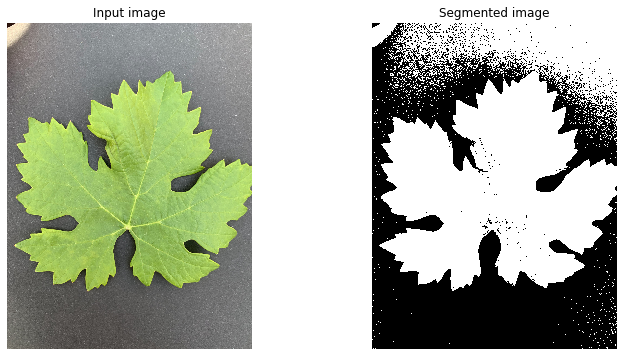

In [55]:
img = io.imread(orig_images[4])
#semantic_seg(img)

Z = img.reshape((-1,4))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#criteria = (cv2.TERM_CRITERIA_EPS , 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
seg_grey = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
ret2,seg_binary1 = cv2.threshold(seg_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret,ret2)
kernel = np.ones((5,5),np.uint8)
seg_binary2 = cv2.dilate(seg_binary1,kernel=kernel,iterations=1)
_,seg_binary3 = cv2.threshold(seg_binary2,127,255,cv2.THRESH_BINARY_INV)

#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6), sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(seg_binary1,cmap='gray')
ax2.set_title('Segmented image')

"""
ax3.axis('off')
ax3.imshow(seg_binary1,cmap='gray')
ax3.set_title('Segmented image binary')

ax4.axis('off')
ax4.imshow(seg_binary3,cmap='gray')
ax4.set_title('Final segmented image')
"""
plt.show()


92.0


Text(0.5, 1.0, 'GT binary')

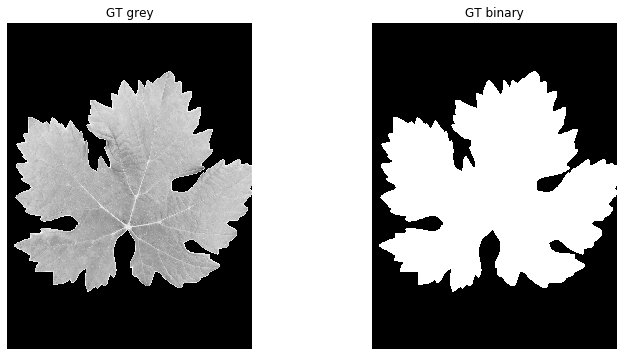

In [47]:
gt_img = cv2.imread(nb_images[4],0)
gt_img[gt_img == 255]=0
#gt_grey = cv2.cvtColor(gt_img, cv2.COLOR_RGB2GRAY)
ret,gt_binary = cv2.threshold(gt_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(gt_img,cmap='gray')
ax1.set_title('GT grey')

ax2.axis('off')
ax2.imshow(gt_binary,cmap='gray')
ax2.set_title('GT binary')

In [56]:
intersection = np.logical_and(gt_binary, seg_binary1)
union = np.logical_or(gt_binary, seg_binary1)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.7138243595771079

In [15]:
def semantic_seg(orig_img,nb_img,criteria,center,dilate):
    #ground truth image
    gt_img = cv2.imread(nb_img,0)
    #print(gt_img.shape)
    gt_img[gt_img == 255]=0
    _,gt_binary = cv2.threshold(gt_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    #processing the original image
    in_img = cv2.imread(orig_img,1)
    #print(in_img.shape)
    Z = in_img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define number of clusters(K), criteria and apply kmeans()
    K = 2

    if criteria == 'epsilon':
        criteria = (cv2.TERM_CRITERIA_EPS, 10, 1.0)
    else:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    
    if center == 'RANDOM':
        flag = cv2.KMEANS_RANDOM_CENTERS
    else:
        flag = cv2.KMEANS_PP_CENTERS
        
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,flag)    
    
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((in_img.shape))
    seg_grey = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
    ret2,seg_binary = cv2.threshold(seg_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if dilate == 1:
        kernel = np.ones((3,3),np.uint8)
        seg_binary = cv2.dilate(seg_binary,kernel=kernel,iterations=1)

    
    intersection = np.logical_and(gt_binary, seg_binary)
    union = np.logical_or(gt_binary, seg_binary)
    iou_score1 = np.sum(intersection) / np.sum(union)
    
    _,seg_binary = cv2.threshold(seg_binary,127,255,cv2.THRESH_BINARY_INV)
    intersection = np.logical_and(gt_binary, seg_binary)
    union = np.logical_or(gt_binary, seg_binary)
    iou_score2 = np.sum(intersection) / np.sum(union)
    
    iou_score = max(iou_score1,iou_score2)
    #print(iou_score)
    return iou_score



In [16]:
centers = ['RANDOM','PP']
dilate = [0,1]
criteria = ['epsilon','eps_max']
raw_images = np.column_stack((orig_images,nb_images))
images = [(img,c,d,e) for img in raw_images for c in centers for d in dilate for e in criteria]
images_df = pd.DataFrame(images,columns=['image','centers','dilate','criteria'])
images_df['orig_img'] = images_df['image'].apply(lambda x: x[0])
images_df['nb_img'] = images_df['image'].apply(lambda x: x[1])
images_df.drop('image',axis=1,inplace=True)
cols = ['orig_img','nb_img','criteria','centers','dilate']
images_df = images_df[cols]
images_df.head()

,orig_img,nb_img,criteria,centers,dilate
0,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,0
1,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,RANDOM,0
2,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,1
3,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,RANDOM,1
4,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,PP,0


In [17]:
#semantic_seg(images_df.iloc[80,0],images_df.iloc[80,1],'RANDOM',1,'eps_max')

In [18]:
images_df['IOU_score'] = images_df.apply(lambda x: semantic_seg(x.orig_img,x.nb_img,x.criteria,x.centers,x.dilate),axis=1)
images_df.head()

,orig_img,nb_img,criteria,centers,dilate,IOU_score
0,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,0,0.687758
1,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,RANDOM,0,0.687758
2,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,1,0.619057
3,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,RANDOM,1,0.619066
4,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,PP,0,0.727295


In [19]:
images_df

,orig_img,nb_img,criteria,centers,dilate,IOU_score
0,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,0,0.687758
1,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,RANDOM,0,0.687758
2,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,1,0.619057
3,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,RANDOM,1,0.619066
4,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,PP,0,0.727295
5,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,PP,0,0.704545
6,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,PP,1,0.631085
7,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,eps_max,PP,1,0.635850
8,leaf_images\Cabernet_Franc_Old\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide10.PNG,epsilon,RANDOM,0,0.364094
9,leaf_images\Cabernet_Franc_Old\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide10.PNG,eps_max,RANDOM,0,0.361723


In [20]:
idx = images_df.groupby(['orig_img'])['IOU_score'].transform(max) == images_df['IOU_score']
best_segmented = images_df[idx].drop_duplicates(subset=['orig_img'])

In [21]:
images_df.to_csv('images_combination_iou.csv')
best_segmented.to_csv('images_best_iou.csv')

In [22]:
best_segmented

,orig_img,nb_img,criteria,centers,dilate,IOU_score
4,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,PP,0,0.727295
14,leaf_images\Cabernet_Franc_Old\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide10.PNG,epsilon,PP,1,0.403547
20,leaf_images\Cabernet_Franc_Old\ORIG\Slide2.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide2.PNG,epsilon,PP,0,0.939036
24,leaf_images\Cabernet_Franc_Old\ORIG\Slide3.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide3.PNG,epsilon,RANDOM,0,0.756248
37,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,eps_max,PP,0,0.729696
41,leaf_images\Cabernet_Franc_Old\ORIG\Slide5.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide5.PNG,eps_max,RANDOM,0,0.836021
53,leaf_images\Cabernet_Franc_Old\ORIG\Slide6.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide6.PNG,eps_max,PP,0,0.567799
58,leaf_images\Cabernet_Franc_Old\ORIG\Slide7.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide7.PNG,epsilon,RANDOM,1,0.519404
67,leaf_images\Cabernet_Franc_Old\ORIG\Slide8.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide8.PNG,eps_max,RANDOM,1,0.602287
73,leaf_images\Cabernet_Franc_Old\ORIG\Slide9.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide9.PNG,eps_max,RANDOM,0,0.790357


# Meta learning model

In [23]:
from sklearn.neighbors import KNeighborsClassifier

X = np.array(features.drop(['image'],axis=1))
y = np.array(features['image'])
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2,random_state=seed)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train) 
  
# Predict on dataset which model has not seen before 
print(y_test)
print(knn.predict(X_test))

['leaf_images\\Szurkebarat_Young\\ORIG\\Slide5.PNG'
 'leaf_images\\Sargamuskotaly_Old\\ORIG\\Slide10.PNG'
 'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide1.PNG'
 'leaf_images\\Szurkebarat_Young\\ORIG\\Slide10.PNG'
 'leaf_images\\Kekfrankos_Young\\ORIG\\Slide10.PNG'
 'leaf_images\\Szurkebarat_Young\\ORIG\\Slide9.PNG'
 'leaf_images\\Sargamuskotaly_Old\\ORIG\\Slide4.PNG'
 'leaf_images\\Tramini_Old\\ORIG\\Slide4.PNG'
 'leaf_images\\Kekfrankos_Old\\ORIG\\Slide3.PNG'
 'leaf_images\\Szurkebarat_Young\\ORIG\\Slide2.PNG'
 'leaf_images\\Szurkebarat_Old\\ORIG\\Slide3.PNG'
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide4.PNG'
 'leaf_images\\Sargamuskotaly_Old\\ORIG\\Slide5.PNG'
 'leaf_images\\Kekfrankos_Young\\ORIG\\Slide4.PNG'
 'leaf_images\\Szurkebarat_Young\\ORIG\\Slide3.PNG'
 'leaf_images\\Kekfrankos_Young\\ORIG\\Slide7.PNG'
 'leaf_images\\Tramini_Old\\ORIG\\Slide8.PNG']
['leaf_images\\Kekfrankos_Young\\ORIG\\Slide2.PNG'
 'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide8.PNG'
 'leaf_images\\Kekfra

In [24]:
y_test

array(['leaf_images\\Szurkebarat_Young\\ORIG\\Slide5.PNG',
       'leaf_images\\Sargamuskotaly_Old\\ORIG\\Slide10.PNG',
       'leaf_images\\Cabernet_Franc_Young\\ORIG\\Slide1.PNG',
       'leaf_images\\Szurkebarat_Young\\ORIG\\Slide10.PNG',
       'leaf_images\\Kekfrankos_Young\\ORIG\\Slide10.PNG',
       'leaf_images\\Szurkebarat_Young\\ORIG\\Slide9.PNG',
       'leaf_images\\Sargamuskotaly_Old\\ORIG\\Slide4.PNG',
       'leaf_images\\Tramini_Old\\ORIG\\Slide4.PNG',
       'leaf_images\\Kekfrankos_Old\\ORIG\\Slide3.PNG',
       'leaf_images\\Szurkebarat_Young\\ORIG\\Slide2.PNG',
       'leaf_images\\Szurkebarat_Old\\ORIG\\Slide3.PNG',
       'leaf_images\\Cabernet_Franc_Old\\ORIG\\Slide4.PNG',
       'leaf_images\\Sargamuskotaly_Old\\ORIG\\Slide5.PNG',
       'leaf_images\\Kekfrankos_Young\\ORIG\\Slide4.PNG',
       'leaf_images\\Szurkebarat_Young\\ORIG\\Slide3.PNG',
       'leaf_images\\Kekfrankos_Young\\ORIG\\Slide7.PNG',
       'leaf_images\\Tramini_Old\\ORIG\\Slide8.PNG'], dtype=

In [25]:
matched_images = pd.DataFrame(data=y_test,columns=['input_img'])
matched_images['closest_match'] = knn.predict(X_test)
key_cols=['orig_img']
par_cols = ['criteria','centers','dilate']
merge_cols=key_cols+par_cols

In [26]:
images_wPar = pd.merge(matched_images,best_segmented[merge_cols],left_on='closest_match',right_on='orig_img',right_index=False).drop(key_cols,axis=1)
images_wPar

,input_img,closest_match,criteria,centers,dilate
0,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Kekfrankos_Young\ORIG\Slide2.PNG,epsilon,RANDOM,0
1,leaf_images\Cabernet_Franc_Young\ORIG\Slide1.PNG,leaf_images\Kekfrankos_Young\ORIG\Slide2.PNG,epsilon,RANDOM,0
2,leaf_images\Sargamuskotaly_Old\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\ORIG\Slide8.PNG,eps_max,RANDOM,1
3,leaf_images\Kekfrankos_Young\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\ORIG\Slide8.PNG,eps_max,RANDOM,1
4,leaf_images\Szurkebarat_Young\ORIG\Slide10.PNG,leaf_images\Kekfrankos_Old\ORIG\Slide6.PNG,epsilon,RANDOM,0
5,leaf_images\Szurkebarat_Young\ORIG\Slide3.PNG,leaf_images\Kekfrankos_Old\ORIG\Slide6.PNG,epsilon,RANDOM,0
6,leaf_images\Szurkebarat_Young\ORIG\Slide9.PNG,leaf_images\Szurkebarat_Young\ORIG\Slide1.PNG,epsilon,RANDOM,0
7,leaf_images\Sargamuskotaly_Old\ORIG\Slide4.PNG,leaf_images\Sargamuskotaly_Old\ORIG\Slide3.PNG,epsilon,RANDOM,1
8,leaf_images\Tramini_Old\ORIG\Slide4.PNG,leaf_images\Szurkebarat_Old\ORIG\Slide6.PNG,eps_max,PP,1
9,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Old\ORIG\Slide6.PNG,eps_max,PP,1


# Comparison (between grid search and meta learning)

In [27]:
def meta_search(images):
    #read test images to a data frame
    features = pd.DataFrame(images,columns=['image'])
    
    #extract features
    features['mean'] = features['image'].apply(channel_mean)
    features['mean_r'] = features['mean'].apply(lambda x: x[2])
    features['mean_g'] = features['mean'].apply(lambda x: x[1])
    features['mean_b'] = features['mean'].apply(lambda x: x[0])
    features['mean_h'] = features['mean'].apply(lambda x: x[3])
    features['mean_s'] = features['mean'].apply(lambda x: x[4])
    features['mean_v'] = features['mean'].apply(lambda x: x[5])
    features['std'] = features['image'].apply(channel_std)
    features['std_r'] = features['std'].apply(lambda x: x[2])
    features['std_g'] = features['std'].apply(lambda x: x[1])
    features['std_b'] = features['std'].apply(lambda x: x[0])
    features['std_h'] = features['std'].apply(lambda x: x[3])
    features['std_s'] = features['std'].apply(lambda x: x[4])
    features['std_v'] = features['std'].apply(lambda x: x[5])
    features['image_size'] = features['image'].apply(getImageSize)
    features['dimension'] = features['image'].apply(getDimension)
    features['width'] = features['dimension'].apply(lambda x: x[0])
    features['height'] = features['dimension'].apply(lambda x: x[1])
    features['blurness'] = features['image'].apply(getBlurnessScore)
    features['dullness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'black'))
    features['whiteness'] = features['image'].apply(lambda x : perform_color_analysis(x, 'white'))
    #features['exif_meta'] = features['image'].apply(getExif)
    features['c_info'] = features['image'].apply(contour_info)
    features['total_cntr_cnt'] = features['c_info'].apply(lambda x: x[0])
    features['ext_cntr_cnt'] = features['c_info'].apply(lambda x: x[1])
    features['cnt1_perc'] = features['c_info'].apply(lambda x: x[2][0])
    features['cnt1to5_perc'] = features['c_info'].apply(lambda x: x[2][1])
    features['cnt1to10_perc'] = features['c_info'].apply(lambda x: x[2][2])
    features.drop(['mean','std','dimension','c_info'],axis=1,inplace=True)
    
    #perform 1-nn to get the closest image from the trained set
    X = np.array(features.drop(['image'],axis=1))
    y = np.array(features['image'])
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train) 
    matched_images = pd.DataFrame(data=y_test,columns=['input_img'])
    matched_images['closest_match'] = knn.predict(X_test)
    key_cols=['orig_img']
    par_cols = ['criteria','centers','dilate']
    merge_cols=key_cols+par_cols
    images_wPar = pd.merge(matched_images,best_segmented[merge_cols],left_on='closest_match',right_on='orig_img',right_index=False).drop(key_cols,axis=1)

    #get the segmentation with the exracted hyper-parameters
    images_wPar['nb_img'] = images_wPar['input_img'].apply(lambda x: x.replace("\\ORIG\\","\\NB\\"))
    images_wPar['IOU_score'] = images_wPar.apply(lambda x: semantic_seg(x.input_img,x.nb_img,x.criteria,x.centers,x.dilate),axis=1)
    return images_wPar

In [28]:
%%time
test_results = meta_search(y_test)
idx = test_results.groupby(['input_img'])['IOU_score'].transform(max) == test_results['IOU_score']
meta_results = test_results[idx].drop_duplicates(subset=['input_img'])
meta_results

Wall time: 2min 40s


,input_img,closest_match,criteria,centers,dilate,nb_img,IOU_score
0,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Kekfrankos_Young\ORIG\Slide2.PNG,epsilon,RANDOM,0,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,0.931722
1,leaf_images\Cabernet_Franc_Young\ORIG\Slide1.PNG,leaf_images\Kekfrankos_Young\ORIG\Slide2.PNG,epsilon,RANDOM,0,leaf_images\Cabernet_Franc_Young\NB\Slide1.PNG,0.942408
2,leaf_images\Sargamuskotaly_Old\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\ORIG\Slide8.PNG,eps_max,RANDOM,1,leaf_images\Sargamuskotaly_Old\NB\Slide10.PNG,0.352935
3,leaf_images\Kekfrankos_Young\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\ORIG\Slide8.PNG,eps_max,RANDOM,1,leaf_images\Kekfrankos_Young\NB\Slide10.PNG,0.532408
4,leaf_images\Szurkebarat_Young\ORIG\Slide10.PNG,leaf_images\Kekfrankos_Old\ORIG\Slide6.PNG,epsilon,RANDOM,0,leaf_images\Szurkebarat_Young\NB\Slide10.PNG,0.964448
5,leaf_images\Szurkebarat_Young\ORIG\Slide3.PNG,leaf_images\Kekfrankos_Old\ORIG\Slide6.PNG,epsilon,RANDOM,0,leaf_images\Szurkebarat_Young\NB\Slide3.PNG,0.980606
6,leaf_images\Szurkebarat_Young\ORIG\Slide9.PNG,leaf_images\Szurkebarat_Young\ORIG\Slide1.PNG,epsilon,RANDOM,0,leaf_images\Szurkebarat_Young\NB\Slide9.PNG,0.951790
7,leaf_images\Sargamuskotaly_Old\ORIG\Slide4.PNG,leaf_images\Sargamuskotaly_Old\ORIG\Slide3.PNG,epsilon,RANDOM,1,leaf_images\Sargamuskotaly_Old\NB\Slide4.PNG,0.642445
8,leaf_images\Tramini_Old\ORIG\Slide4.PNG,leaf_images\Szurkebarat_Old\ORIG\Slide6.PNG,eps_max,PP,1,leaf_images\Tramini_Old\NB\Slide4.PNG,0.524951
9,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Old\ORIG\Slide6.PNG,eps_max,PP,1,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,0.651271


In [29]:
def grid_search(images):
    centers = ['RANDOM','PP']
    dilate = [0,1]
    criteria = ['epsilon','eps_max']
    
    nb_images = [x.replace("\\ORIG\\","\\NB\\") for x in images]
    raw_images = np.column_stack((images,nb_images))
    images = [(img,c,d,e) for img in raw_images for c in centers for d in dilate for e in criteria]
    images_df = pd.DataFrame(images,columns=['image','centers','dilate','criteria'])
    images_df['orig_img'] = images_df['image'].apply(lambda x: x[0])
    images_df['nb_img'] = images_df['image'].apply(lambda x: x[1])
    images_df.drop('image',axis=1,inplace=True)
    cols = ['orig_img','nb_img','criteria','centers','dilate']
    images_df = images_df[cols]

    images_df['IOU_score'] = images_df.apply(lambda x: semantic_seg(x.orig_img,x.nb_img,x.criteria,x.centers,x.dilate),axis=1)
    idx = images_df.groupby(['orig_img'])['IOU_score'].transform(max) == images_df['IOU_score']
    best_segmented = images_df[idx].drop_duplicates(subset=['orig_img'])
    return best_segmented

In [30]:
%%time
grid_results = grid_search(y_test)
grid_results

Wall time: 9min 26s


,orig_img,nb_img,criteria,centers,dilate,IOU_score
5,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,eps_max,PP,0,0.931736
11,leaf_images\Sargamuskotaly_Old\ORIG\Slide10.PNG,leaf_images\Sargamuskotaly_Old\NB\Slide10.PNG,eps_max,RANDOM,1,0.352549
16,leaf_images\Cabernet_Franc_Young\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Young\NB\Slide1.PNG,epsilon,RANDOM,0,0.942538
24,leaf_images\Szurkebarat_Young\ORIG\Slide10.PNG,leaf_images\Szurkebarat_Young\NB\Slide10.PNG,epsilon,RANDOM,0,0.964519
33,leaf_images\Kekfrankos_Young\ORIG\Slide10.PNG,leaf_images\Kekfrankos_Young\NB\Slide10.PNG,eps_max,RANDOM,0,0.593759
41,leaf_images\Szurkebarat_Young\ORIG\Slide9.PNG,leaf_images\Szurkebarat_Young\NB\Slide9.PNG,eps_max,RANDOM,0,0.951991
54,leaf_images\Sargamuskotaly_Old\ORIG\Slide4.PNG,leaf_images\Sargamuskotaly_Old\NB\Slide4.PNG,epsilon,PP,1,0.643204
61,leaf_images\Tramini_Old\ORIG\Slide4.PNG,leaf_images\Tramini_Old\NB\Slide4.PNG,eps_max,PP,0,0.542285
66,leaf_images\Kekfrankos_Old\ORIG\Slide3.PNG,leaf_images\Kekfrankos_Old\NB\Slide3.PNG,epsilon,RANDOM,1,0.413996
76,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,epsilon,PP,0,0.746025


In [58]:
#pd.crosstab(test_results[par_cols],grid_results[par_cols],rownames=['meta'],colnames=['grid'])
for par in par_cols:
    print("----Match in:",par,"----")
    #print(pd.crosstab(np.array(meta_results[par]),np.array(grid_results[par]),rownames=['meta'],colnames=['grid']))
    display(pd.crosstab(np.array(meta_results[par]),np.array(grid_results[par]),rownames=['meta'],colnames=['grid'],normalize=True))
    print("----***************----")

----Match in: criteria ----


grid,eps_max,epsilon
meta,,
eps_max,0.176471,0.235294
epsilon,0.529412,0.058824


----***************----
----Match in: centers ----


grid,PP,RANDOM
meta,,
PP,0.117647,0.176471
RANDOM,0.294118,0.411765


----***************----
----Match in: dilate ----


grid,0,1
meta,,
0,0.352941,0.235294
1,0.352941,0.058824


----***************----


In [33]:
IOU_comparison = pd.merge(meta_results[['input_img','IOU_score']],grid_results[['orig_img','IOU_score']],left_on='input_img',right_on='orig_img',suffixes=('_meta','_grid')).drop(['orig_img'],axis=1)
IOU_comparison

,input_img,IOU_score_meta,IOU_score_grid
0,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,0.931722,0.931736
1,leaf_images\Cabernet_Franc_Young\ORIG\Slide1.PNG,0.942408,0.942538
2,leaf_images\Sargamuskotaly_Old\ORIG\Slide10.PNG,0.352935,0.352549
3,leaf_images\Kekfrankos_Young\ORIG\Slide10.PNG,0.532408,0.593759
4,leaf_images\Szurkebarat_Young\ORIG\Slide10.PNG,0.964448,0.964519
5,leaf_images\Szurkebarat_Young\ORIG\Slide3.PNG,0.980606,0.980577
6,leaf_images\Szurkebarat_Young\ORIG\Slide9.PNG,0.951790,0.951991
7,leaf_images\Sargamuskotaly_Old\ORIG\Slide4.PNG,0.642445,0.643204
8,leaf_images\Tramini_Old\ORIG\Slide4.PNG,0.524951,0.542285
9,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,0.651271,0.746025


In [34]:
IOU_comparison['delta'] = IOU_comparison.IOU_score_grid - IOU_comparison.IOU_score_meta
IOU_comparison

,input_img,IOU_score_meta,IOU_score_grid,delta
0,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,0.931722,0.931736,0.000014
1,leaf_images\Cabernet_Franc_Young\ORIG\Slide1.PNG,0.942408,0.942538,0.000130
2,leaf_images\Sargamuskotaly_Old\ORIG\Slide10.PNG,0.352935,0.352549,-0.000386
3,leaf_images\Kekfrankos_Young\ORIG\Slide10.PNG,0.532408,0.593759,0.061351
4,leaf_images\Szurkebarat_Young\ORIG\Slide10.PNG,0.964448,0.964519,0.000071
5,leaf_images\Szurkebarat_Young\ORIG\Slide3.PNG,0.980606,0.980577,-0.000029
6,leaf_images\Szurkebarat_Young\ORIG\Slide9.PNG,0.951790,0.951991,0.000200
7,leaf_images\Sargamuskotaly_Old\ORIG\Slide4.PNG,0.642445,0.643204,0.000758
8,leaf_images\Tramini_Old\ORIG\Slide4.PNG,0.524951,0.542285,0.017334
9,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,0.651271,0.746025,0.094754


In [36]:
print(IOU_comparison.delta.mean(),IOU_comparison.delta.std())

0.01318625568988444 0.02619918021720116


# Additional info for reporting

In [38]:
best_match =  pd.merge(grid_results['orig_img'],images_df,on='orig_img',)
best_match.head()

,orig_img,nb_img,criteria,centers,dilate,IOU_score
0,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,epsilon,RANDOM,0,0.931849
1,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,eps_max,RANDOM,0,0.931728
2,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,epsilon,RANDOM,1,0.901041
3,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,eps_max,RANDOM,1,0.901225
4,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,epsilon,PP,0,0.931713


In [39]:
best_match['IOU_max'] = best_match.groupby(['orig_img'])['IOU_score'].transform(max)
best_match['IOU_min'] = best_match.groupby(['orig_img'])['IOU_score'].transform(min)
best_match.head()

,orig_img,nb_img,criteria,centers,dilate,IOU_score,IOU_max,IOU_min
0,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,epsilon,RANDOM,0,0.931849,0.931849,0.900971
1,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,eps_max,RANDOM,0,0.931728,0.931849,0.900971
2,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,epsilon,RANDOM,1,0.901041,0.931849,0.900971
3,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,eps_max,RANDOM,1,0.901225,0.931849,0.900971
4,leaf_images\Szurkebarat_Young\ORIG\Slide5.PNG,leaf_images\Szurkebarat_Young\NB\Slide5.PNG,epsilon,PP,0,0.931713,0.931849,0.900971


In [42]:
best_match['IOU_delta'] = best_match['IOU_max'] - best_match['IOU_min']
best_idx = best_match['IOU_delta'].max() == best_match['IOU_delta']
to_display = best_match[best_idx]
to_display

,orig_img,nb_img,criteria,centers,dilate,IOU_score,IOU_max,IOU_min,IOU_delta
72,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,epsilon,RANDOM,0,0.745950,0.746196,0.648513,0.097682
73,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,eps_max,RANDOM,0,0.746094,0.746196,0.648513,0.097682
74,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,epsilon,RANDOM,1,0.650525,0.746196,0.648513,0.097682
75,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,eps_max,RANDOM,1,0.651047,0.746196,0.648513,0.097682
76,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,epsilon,PP,0,0.746196,0.746196,0.648513,0.097682
77,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,eps_max,PP,0,0.745947,0.746196,0.648513,0.097682
78,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,epsilon,PP,1,0.648513,0.746196,0.648513,0.097682
79,leaf_images\Szurkebarat_Young\ORIG\Slide2.PNG,leaf_images\Szurkebarat_Young\NB\Slide2.PNG,eps_max,PP,1,0.650765,0.746196,0.648513,0.097682


In [44]:
images_df[images_df['orig_img'] == 'leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG']

,orig_img,nb_img,criteria,centers,dilate,IOU_score
32,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,epsilon,RANDOM,0,0.726209
33,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,eps_max,RANDOM,0,0.717535
34,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,epsilon,RANDOM,1,0.675190
35,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,eps_max,RANDOM,1,0.669170
36,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,epsilon,PP,0,0.713710
37,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,eps_max,PP,0,0.729696
38,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,epsilon,PP,1,0.664620
39,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,eps_max,PP,1,0.667080


In [62]:
orig_range = images_df.copy()
orig_range['IOU_max'] = images_df.groupby(['orig_img'])['IOU_score'].transform(max)
orig_range['IOU_min'] = images_df.groupby(['orig_img'])['IOU_score'].transform(min)
orig_range.drop_duplicates(subset=['orig_img'],inplace=True)
orig_range['IOU_delta'] = orig_range['IOU_max'] - orig_range['IOU_min']
display(orig_range.head())
display(orig_range.IOU_delta.mean(),orig_range.IOU_delta.std())

,orig_img,nb_img,criteria,centers,dilate,IOU_score,IOU_max,IOU_min,IOU_delta
0,leaf_images\Cabernet_Franc_Old\ORIG\Slide1.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide1.PNG,epsilon,RANDOM,0,0.687758,0.727295,0.619057,0.108239
8,leaf_images\Cabernet_Franc_Old\ORIG\Slide10.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide10.PNG,epsilon,RANDOM,0,0.364094,0.403547,0.361723,0.041825
16,leaf_images\Cabernet_Franc_Old\ORIG\Slide2.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide2.PNG,epsilon,RANDOM,0,0.939033,0.939036,0.910689,0.028346
24,leaf_images\Cabernet_Franc_Old\ORIG\Slide3.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide3.PNG,epsilon,RANDOM,0,0.756248,0.756248,0.686459,0.069789
32,leaf_images\Cabernet_Franc_Old\ORIG\Slide4.PNG,leaf_images\Cabernet_Franc_Old\NB\Slide4.PNG,epsilon,RANDOM,0,0.726209,0.729696,0.664620,0.065076


0.03402030811742666

0.029852226648100333